# **Lab 7.2 CNN**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [3]:
def load_data(path,class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Resize image to 28x28
        transforms.Pad(padding=28,padding_mode='reflect'),
        transforms.RandomRotation(15),  # Apply random rotation
        transforms.CenterCrop(28),  # Apply center crop
        transforms.Grayscale(),  # Convert to grayscale
        transforms.ToTensor()
    ])

    # Load dataset with ImageFolder
    full_dataset = ImageFolder(root=path, transform=transform)
    # print(full_dataset.classes)
    # เอาเฉพาะประเภทที่เลือก [0,1]
    class_to_idx = full_dataset.class_to_idx
    selected_indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.classes[label] in class_names]
    # print(selected_indices)
    # จัดให้ข้อมูลทั้งหมด มีแค่ 0,1 (ประเภทที่เลือก)
    subset_dataset = Subset(full_dataset, selected_indices)

    # # Create DataLoader for training and testing (using 80/20 split)
    train_size = int(0.8 * len(subset_dataset))
    test_size = len(subset_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])
    
    # # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    train_class_0 = sum(1 for _, label in train_loader.dataset if label == 0)
    train_class_1 = sum(1 for _, label in train_loader.dataset if label == 1)
    test_class_0 = sum(1 for _, label in test_loader.dataset if label == 0)
    test_class_1 = sum(1 for _, label in test_loader.dataset if label == 1)
    
    print("📃Train Dataset:")
    print("     Number of images in class 0:", train_class_0)
    print("     Number of images in class 1:", train_class_1)
    print("     Number of training samples:", len(train_loader.dataset))
    print("📃Test Dataset:")
    print("     Number of images in class 0:", test_class_0)
    print("     Number of images in class 1:", test_class_1)
    print("     Number of training samples:", len(test_loader.dataset))
    # ### END CODE HERE ###
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


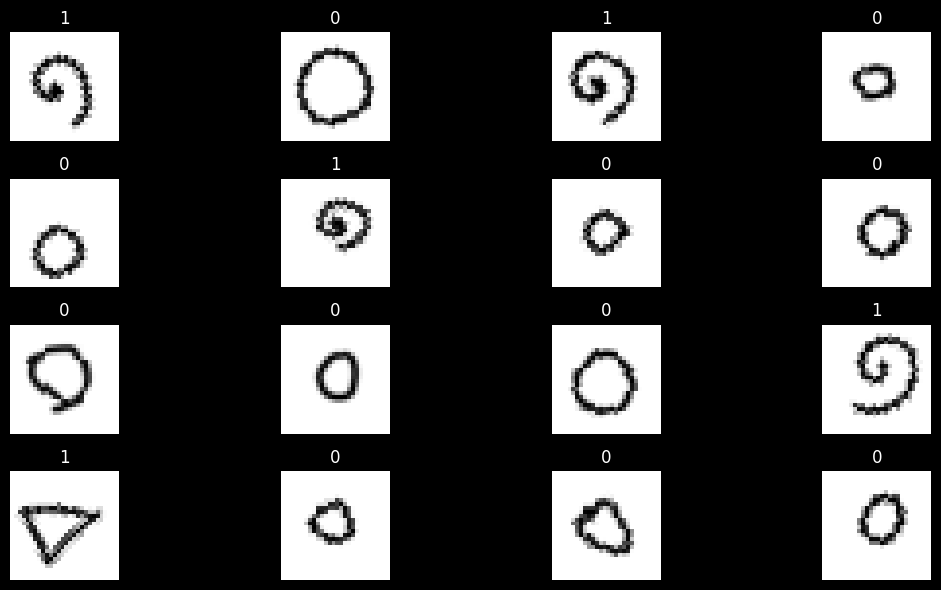

</details>

📃Train Dataset:
     Number of images in class 0: 316
     Number of images in class 1: 305
     Number of training samples: 621
📃Test Dataset:
     Number of images in class 0: 72
     Number of images in class 1: 84
     Number of training samples: 156


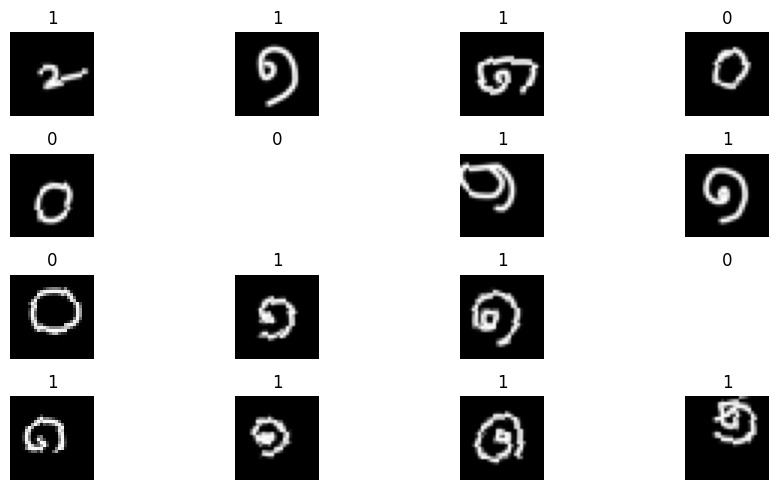

In [4]:
### START CODE HERE ###
def imshow_grid(images,labels):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = images[i]
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        # print(img.shape)
        plt.imshow(img, cmap="Grays")
        a.axis("off")
        
        plt.title(str(labels[i].item()))
        # print(img.shape)
    plt.tight_layout()
    plt.show()
    
path = 'thai-handwriting-number.appspot.com'  # Replace with your actual dataset path
class_names = ['0', '1'] 
train_loader, test_loader = load_data(path, class_names)
images, labels = next(iter(train_loader))
imshow_grid(images,labels)

### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [20]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1,padding=0)
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten the output from conv layers
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.sigmoid(x)
        
        return x
        
        

### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [ ]:
def train(model,opt,loss_fn,train_loader,test_loader,epochs=10,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###







    ### END CODE HERE ###

Use your `train()` function to train models.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Try to load the weights into the model and the confusion matrix.

In [ ]:
### START CODE HERE ###





### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [ ]:
### START CODE HERE ###





### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.
